In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import multiprocessing
import time

# --- 1. LOAD AND PREP STATIC DATA ---
# We load the CSV once globally to avoid overhead

df_2019 = pd.read_csv('./Frank2019_clean_1.csv')

if 'Unnamed: 0' in df_2019.columns:
    df_2019.drop(['Unnamed: 0'], axis=1, inplace=True)

X_raw = df_2019.drop('SalePrice', axis=1)
y_raw = df_2019['SalePrice']

# Scale the X features globally
scaler = StandardScaler()
X_scale_array = scaler.fit_transform(X_raw)
X_scale = pd.DataFrame(X_scale_array, columns=X_raw.columns)


# --- 2. HELPER FUNCTIONS ---

def input_process(X_train, X_test):
    # spatial cols
    X_train_space = X_train[['X', 'Y']].to_numpy()
    X_test_space = X_test[['X', 'Y']].to_numpy()

    # non-spatial cols
    X_train_Xs = X_train.drop(['X', 'Y'], axis=1).to_numpy()
    X_test_Xs = X_test.drop(['X', 'Y'], axis=1).to_numpy()

    if X_train_Xs.shape[1] > 20:  # do PCA if non-spatial features >20
        pca = PCA(n_components=10)
        X_train_Xs = pca.fit_transform(X_train_Xs)
        X_test_Xs = pca.transform(X_test_Xs)

    return X_train_space, X_test_space, X_train_Xs, X_test_Xs

def cal_dist(X_train_space, X_test_space, X_train_Xs, X_test_Xs, ratio):
    # Distance calculation (Broadcasting)
    dist_space = np.sqrt(((X_train_space[:, :, None] - X_test_space[:, :, None].T) ** 2).sum(1))/X_train_space.shape[1]
    dist_Xs = np.sqrt(((X_train_Xs[:, :, None] - X_test_Xs[:, :, None].T) ** 2).sum(1))/X_train_Xs.shape[1]
    distance = ratio * dist_space + (1 - ratio) * dist_Xs
    return distance

def predict(y_train, X_test, distance, k):
    sorted_distance_indices = np.argsort(distance, axis=0)
    y_pred = np.zeros(X_test.shape[0])
    y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

    for row in range(X_test.shape[0]):
        knn_indices = sorted_distance_indices[:, row][:k]
        knn_dists = distance[knn_indices, row]

        with np.errstate(divide='ignore'):
            weights = 1.0 / knn_dists
        if np.isinf(weights).any():
            weights[np.isinf(weights)] = 1.0

        y_pred[row] = np.average(y_train_np[knn_indices], weights=weights)
    return y_pred

# --- 3. WORKER FUNCTION (PARALLELIZED) ---
def process_single_ratio(ratio, X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, y_train, X_valid, y_valid, k_list):
    """Calculates metrics for one ratio across all K values."""
    #if ratio == 0:
    #    ratio = ratio + 0.0000001

    distance = cal_dist(X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, ratio)
    ratio_results = []

    for k in k_list:
        y_pred = predict(y_train, X_valid, distance, k)
        rmse = np.sqrt(np.mean((y_valid - y_pred)**2))
        mae = metrics.mean_absolute_error(y_valid, y_pred)
        r2 = metrics.r2_score(y_valid, y_pred)
        ratio_results.append([rmse, mae, r2])

    # Find best K for this specific ratio based on MAE (index 1)
    min_index = np.argmin(ratio_results, axis=0)[1]
    best_metrics = ratio_results[min_index] # [RMSE, MAE, R2]

    return {
        'ratio': ratio,
        'mae': best_metrics[1],
        'rmse': best_metrics[0],
        'r2': best_metrics[2],
        'best_k': k_list[min_index]
    }

def process_single_ratio2(ratio_list, X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, y_train, X_valid, y_valid, k):
    """Calculates metrics for one ratio across all K values."""
    #if ratio == 0:
    #    ratio = ratio + 0.0000001

    k_results = []

    for ratio in ratio_list:
        distance = cal_dist(X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, ratio)
        y_pred = predict(y_train, X_valid, distance, k)
        rmse = np.sqrt(np.mean((y_valid - y_pred)**2))
        mae = metrics.mean_absolute_error(y_valid, y_pred)
        r2 = metrics.r2_score(y_valid, y_pred)
        k_results.append([rmse, mae, r2])

    # Find best K for this specific ratio based on MAE (index 1)
    min_index = np.argmin(k_results, axis=0)[1]
    best_metrics = k_results[min_index] # [RMSE, MAE, R2]

    return {
        'k': k,
        'mae': best_metrics[1],
        'rmse': best_metrics[0],
        'r2': best_metrics[2],
        'best_ratio': ratio_list[min_index]
    }

# --- 4. SIMULATION CONTROL ---

def run_simulation(num_replications, X_scale, y, ratio_list, k_list):
    all_records = []

    print(f"Starting simulation with {num_replications} replications...")
    start_time = time.time()

    for i in range(num_replications):
        if i % 10 == 0:
            print(f"Running replication {i}/{num_replications}...")

        # 1. RANDOM SPLIT (Crucial for generalization)
        # We vary random_state by 'i' to ensure different splits every time
        X_train_valid, X_test, y_train_valid, y_test = train_test_split(
            X_scale, y, test_size=0.2, random_state=i
        )

        # Reset indices
        for obj in [X_train_valid, y_train_valid]:
            obj.reset_index(inplace=True, drop=True)

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_valid, y_train_valid, test_size=0.2, random_state=i
        )

        for obj in [X_train, X_valid, y_train, y_valid]:
            obj.reset_index(inplace=True, drop=True)

        # 2. PREP DATA
        X_train_space, X_valid_space, X_train_Xs, X_valid_Xs = input_process(X_train, X_valid)

        # 3. PARALLEL EXECUTION FOR RATIOS
        # We run the ratio search in parallel for THIS replication
        results = Parallel(n_jobs=-1, backend='loky')(
            delayed(process_single_ratio)(
                ratio, X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, y_train, X_valid, y_valid, k_list
            ) for ratio in ratio_list
        )

        # 4. STORE DATA
        for res in results:
            all_records.append({
                'Replication_ID': i,
                'Ratio': res['ratio'],
                'Best_K': res['best_k'],
                'MAE': res['mae'],
                'RMSE': res['rmse'],
                'R2': res['r2']
            })

    total_time = time.time() - start_time
    print(f"Simulation complete in {total_time/60:.2f} minutes.")

    return pd.DataFrame(all_records)

def run_simulation2(num_replications, X_scale, y, ratio_list, k_list):
    all_records = []

    print(f"Starting simulation with {num_replications} replications...")
    start_time = time.time()

    for i in range(num_replications):
        if i % 10 == 0:
            print(f"Running replication {i}/{num_replications}...")

        # 1. RANDOM SPLIT (Crucial for generalization)
        # We vary random_state by 'i' to ensure different splits every time
        X_train_valid, X_test, y_train_valid, y_test = train_test_split(
            X_scale, y, test_size=0.2, random_state=i
        )

        # Reset indices
        for obj in [X_train_valid, y_train_valid]:
            obj.reset_index(inplace=True, drop=True)

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_valid, y_train_valid, test_size=0.2, random_state=i
        )

        for obj in [X_train, X_valid, y_train, y_valid]:
            obj.reset_index(inplace=True, drop=True)

        # 2. PREP DATA
        X_train_space, X_valid_space, X_train_Xs, X_valid_Xs = input_process(X_train, X_valid)

        # 3. PARALLEL EXECUTION FOR RATIOS
        # We run the ratio search in parallel for THIS replication
        results = Parallel(n_jobs=-1, backend='loky')(
            delayed(process_single_ratio2)(
                ratio_list, X_train_space, X_valid_space, X_train_Xs, X_valid_Xs, y_train, X_valid, y_valid, k
            ) for k in k_list
        )

        # 4. STORE DATA
        for res in results:
            all_records.append({
                'Replication_ID': i,
                'Best_Ratio': res['best_ratio'],
                'K': res['k'],
                'MAE': res['mae'],
                'RMSE': res['rmse'],
                'R2': res['r2']
            })

    total_time = time.time() - start_time
    print(f"Simulation complete in {total_time/60:.2f} minutes.")

    return pd.DataFrame(all_records)



In [2]:
# --- 5. EXECUTE AND PLOT ---

# Parameters
ratio_list = [0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0]
k_list = [x for x in range(2, 20, 1)]

# RUN THE SIMULATION
# WARNING: 1000 replications is heavy.
# Start with 10 to test, then change to 1000.
n_reps = 100
df_results = run_simulation(n_reps, X_scale, y_raw, ratio_list, k_list)
#df_results = run_simulation2(n_reps, X_scale, y_raw, ratio_list, k_list)


Starting simulation with 100 replications...
Running replication 0/100...


KeyError: 'ratio'

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_49092\3343346022.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ratio', y='MAE', data=df_results, palette="Set3")


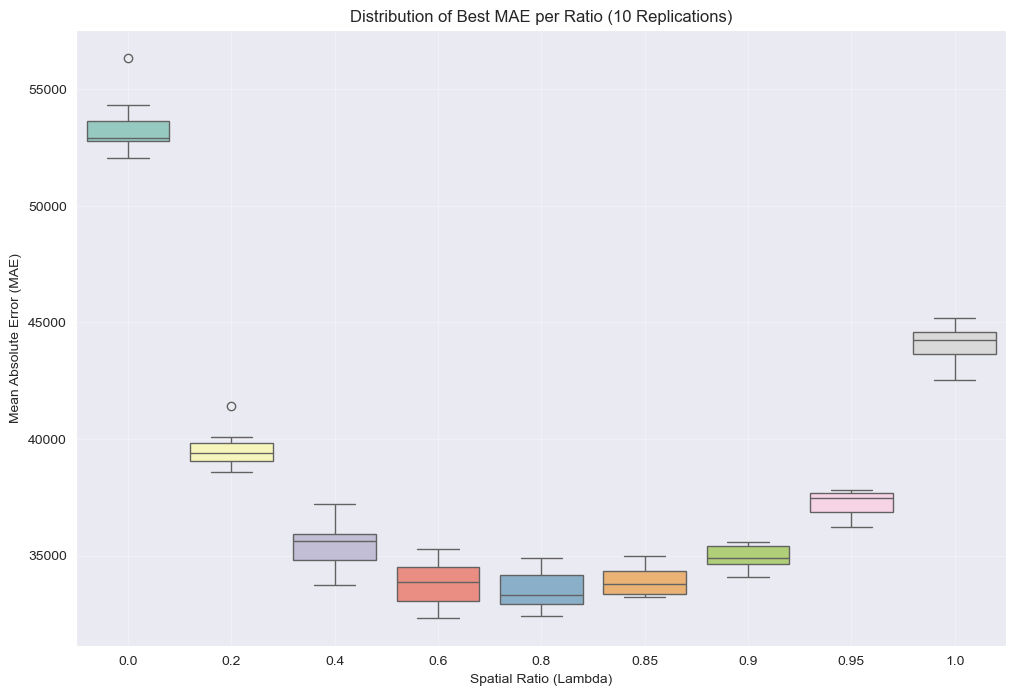


Summary Statistics by Ratio:
               mean          std           min           max
Ratio                                                       
0.80   33478.836641   860.124750  32411.509937  34892.589230
0.60   33810.749026   976.755796  32313.521301  35302.090762
0.85   33890.215330   601.363337  33214.792867  34988.078220
0.90   34952.834787   495.089779  34073.264626  35573.706574
0.40   35438.609118   975.490092  33751.490176  37223.671044
0.95   37238.135948   580.209285  36234.367646  37826.920095
0.20   39542.367709   823.491622  38605.094880  41411.980775
1.00   44038.518414   900.969370  42536.910019  45173.903996
0.00   53343.762452  1235.453774  52047.577132  56329.424934


In [3]:
# --- 6. VISUALIZATION ---

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Ratio', y='MAE', data=df_results, palette="Set3")

plt.title(f'Distribution of Best MAE per Ratio ({n_reps} Replications)')
plt.xlabel('Spatial Ratio (Lambda)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Print summary table
summary = df_results.groupby('Ratio')['MAE'].agg(['mean', 'std', 'min', 'max']).sort_values('mean')
print("\nSummary Statistics by Ratio:")
print(summary)

In [7]:
#df_results.to_csv('./Frank2019_SimulationRes_2.csv', index=True)